# TODO
1. ~~wyznaczanie pojedynczych puzzli~~ - Mikołaj
2. ~~ponumerowanie puzzli~~ - Mikołaj
3. ~~wyznaczanie krawędzi~~ - Bartosz
4. ~~wyznaczanie narożników~~ - Bartosz
5. wykorzystanie narożników do podziału krawędzi na 4 boki
6. szukanie patternów/dopasowywanie krawędzi i/lub kolorów

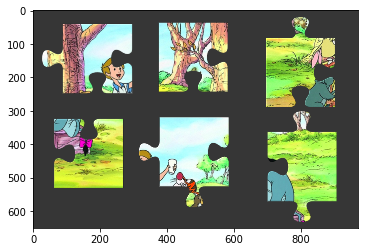

In [229]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

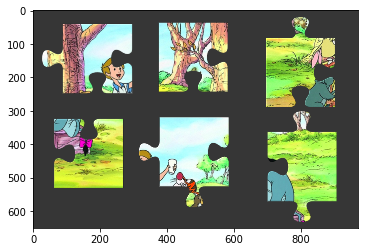

In [284]:
def draw(img):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))


img2 = cv2.imread(os.path.join('img', 'puchatek_puzzle_1.png'))
img2 = cv2.copyMakeBorder(img2, 15, 15, 15, 15, cv2.BORDER_REPLICATE, None)
draw(img2)




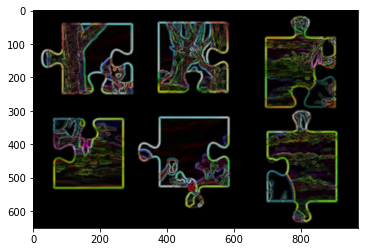

In [285]:
image2 = cv2.imread(os.path.join('img', 'puchatek_puzzle_1.png'))
image2 = cv2.copyMakeBorder(image2, 15, 15, 15, 15, cv2.BORDER_REPLICATE, None)

blur = cv2.GaussianBlur(image2, (7, 7), 2)
h, w = image2.shape[:2]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
draw(gradient)
#jestem bardzo pod wrażeniem że na tym nie znajduje ani troche dobrze

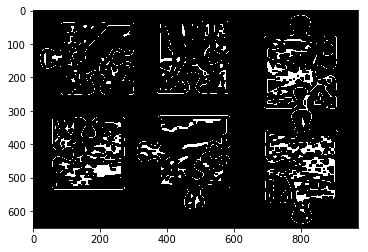

In [286]:
lowerb = np.array([0, 0, 0])
upperb = np.array([20,20, 20])
binary = cv2.inRange(gradient, lowerb, upperb)

draw(binary)


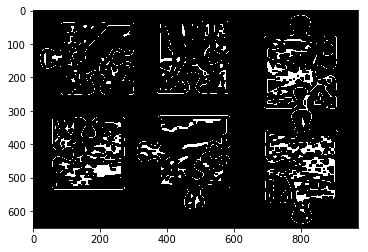

In [287]:
edged = cv2.Canny(binary, 10, 250)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

draw(closed)

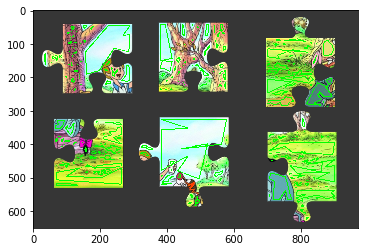

In [288]:
for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)

for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)
draw(binary)


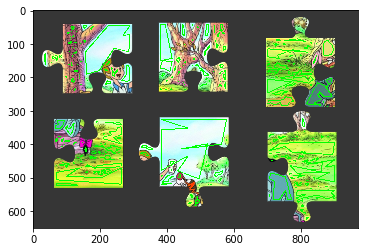

In [289]:
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
draw(foreground)

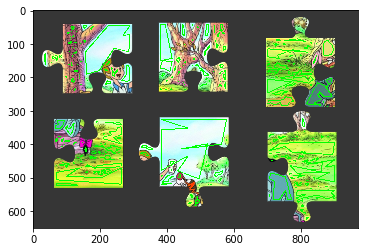

In [290]:
#im2, cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
im2, cnts, hierarchy = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#im2, cnts, hierarchy = cv2.findContours(foreground.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(image2, [approx], -1, (0, 255, 0), 2)
draw(image2)


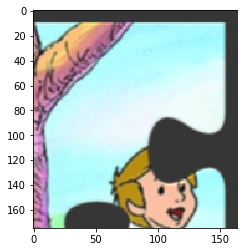

In [283]:

for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if w>50 and h>50:
        new_img=img2[y-15:y+h+15, x-15:x+w+15]
        draw(new_img)


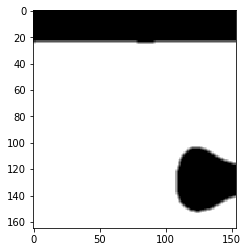

In [267]:
puzz = img2
puzz2= img2
BLACK = [0, 0, 0]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    if w>50 and h>50:
        value = [randint(0, 255), randint(0, 255), randint(0, 255)]
        puzz = img2[y-10:y+h+10, x-10:x+w+10]
        
loc = cv2.cvtColor(puzz, cv2.COLOR_BGR2GRAY)
loc = cv2.medianBlur(loc, ksize=3)
loc = cv2.threshold(loc, 60, 255, cv2.THRESH_BINARY)[1]
loc = cv2.dilate(loc, (5,5))
loc = cv2.medianBlur(loc, ksize=9)
loc = cv2.blur(loc, ksize=(3, 3))

draw(loc)

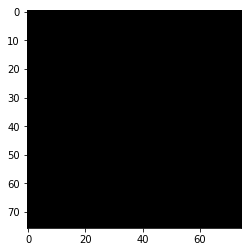

In [228]:
dst = cv2.cornerHarris(np.float32(loc),2,3,0.04)
dst = cv2.dilate(dst,None)
draw(np.uint8(dst))

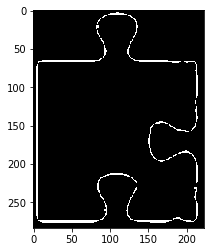

In [82]:
l = np.zeros((dst.shape[0], dst.shape[1]), dtype=np.uint8)

l[dst<0.03*np.min(dst)]=[255]
l[dst>0.03*np.max(dst)]=[255]

draw(l)

In [83]:
lines = cv2.HoughLines(np.uint8(l), 0.1, np.pi/180, 100)

In [84]:
li = []
for el in lines:
    li.append(el[0])

wyn = [[li[0]]]    

res = [li[0]]

for i in range(1, len(li)):
    flag = False
    for k in range(len(res)):
        if (res[k][0]-5 < li[i][0] and li[i][0] < res[k][0]+5) and (res[k][1]-5 < li[i][1] and li[i][1] < res[k][1]+5):
            wyn[k].append(li[i])
            flag = True
    if not flag:
        wyn.append([li[i]])
        res.append(li[i])

moments = []
        
for el in wyn:
    a, b, c = 0, 0, 0
    for e in el:
        a += e[0]
        b += e[1]
        c += 1
    moments.append([a/c, b/c])
    
moments

[[4.9500002066294355, 0.0],
 [212.4499969482422, 0.0],
 [65.95000457763672, 1.5707963705062866],
 [274.45001220703125, 1.5707963705062866]]

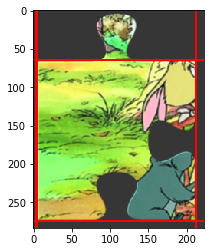

In [85]:
aaaa = puzz.copy()
points = []

for el in moments:
    rho,theta = el[0], el[1]
    a = np.cos(theta)
    b = np.sin(theta)
    
    x0 = a*rho
    y0 = b*rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    points.append([[x1,y1],[x2,y2]])
    
    cv2.line(aaaa, (x1, y1), (x2,y2), (0,0,255), 2)
    
draw(aaaa)

In [86]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [87]:
corners = set()
for i in range(len(points)):
    for k in range(len(points)):
        lx = line_intersection(points[i], points[k])
        if lx is not None:
            corners.add(lx)
            
corners = np.array(list(corners), dtype=np.int32)
corners

array([[  4, 274],
       [212, 274],
       [  4,  65],
       [212,  65]])

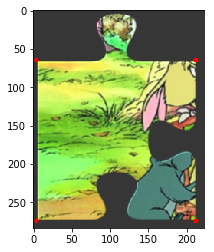

In [73]:
aaaa = puzz.copy()
for el in corners:
    cv2.circle(aaaa, (el[0], el[1]), 3, (0,0,255), -1)
draw(aaaa)

In [ ]:
lu = corners[0]
pu = corners[1]
ld = corners[2]
pd = corners[3]

cx, cy = np.int32(line_intersection([lu,pd],[pu,ld]))

aaaa = puzz.copy()

up = []
down = []
left = []
right = []

padl, padr, padu, padd = 0, 0, 0, 0 

for i in range(0, cy):
    if l[0, cx] != l[i, cx]:
        padu = i
        break

for i in range(l.shape[0]-1, cy, -1):
    if l[l.shape[0]-1, cx] != l[i, cx]:
        padd = i
        break
        
for i in range(0, cx):
    if l[cy, 0] != l[cy, i]:
        padl = i
        break
        
for i in range(l.shape[1]-1, cx, -1):
    if l[cy, l.shape[1]-1] != l[cy, i]:
        padr = i
        break
        
for i in range(l.shape[0]):
    for k in range(l.shape[1]):
        if l[i,k] != 0:
            if k >= lu[1]+5 and k <= pu[1]-5 and (i <= padu+5 or i <= np.mean([lu[0],pu[0]])+5):
                aaaa[i,k]=[0,0,255]
                up.append([i,k])
            if k > ld[1]+5 and k < pd[1]-5 and (i >= padd-5 or i>=np.mean([ld[0],pd[0]])-5):
                aaaa[i,k]=[0,255,255]
                down.append([i,k])
            if i > lu[0]+5 and i < ld[0]-5 and (k <= padl+5 or k<=np.mean([lu[1],ld[1]])+5):
                aaaa[i,k]=[0,120,255]
                left.append([i,k])
            if i > pu[0]+5 and i < pd[0]-5 and (k >= padr-5 or k>=np.mean([pu[0],pd[0]])-5):
                aaaa[i,k]=[255,0,255]
                right.append([i,k])
            
draw(aaaa)


In [ ]:
def check_slides(up, down, left, right):
    if np.std(np.array(up)[:,0]) < 5.0:
        print('góra')
    if np.std(np.array(down)[:,0]) < 5.0:
        print('dół')
    if np.std(np.array(left)[:,1]) < 5.0:
        print('lewo')
    if np.std(np.array(right)[:,1]) < 5.0:
        print('prawo')

check_slides(up, down, left, right)
